# Comprehensive Experiment Data Analysis

##### Note(7/20)
Containing results from three conditioned datesets, with gaussian, median, blackout and destroy-bg ablations. 
Tabled statistics: https://docs.google.com/document/d/1dkbPI0PF8lcrVz4LOKOHBviCjfrji1E6mlKrQdV2fHI/edit?ts=5788e509#


In [200]:
CWD = %pwd
CWD = str(CWD)
import random
import sys
import json
from six.moves import cPickle
import os
import statistics
from collections import defaultdict,Iterable
import scipy

from IPython.core.display import HTML 
from IPython.core.display import Image, display, display_pretty

import numpy as np
from scipy import misc, polyfit, stats
import matplotlib.pyplot as plt
import PIL
# from PIL import Image
%matplotlib inline  


COCO_PATH = os.path.join(CWD,'data','coco')
COCO_ANNO_PATH = os.path.join(COCO_PATH, 'annotations')
COCO_TEXT_PATH = os.path.join(CWD, 'coco-text')
sys.path.insert(0, COCO_TEXT_PATH)
import coco_text as ct
ct = ct.COCO_Text(os.path.join(COCO_PATH, 'COCO_Text.json'))
import ablation
sys.path.insert(0, os.path.join(CWD, 'coco', 'PythonAPI'))
from pycocotools.coco import COCO,mask

loading annotations into memory...
0:00:03.392285
creating index...
index created!


In [201]:
"""
Load Coco data
"""

# load the data from captions
with open(COCO_ANNO_PATH + '/captions_train2014.json') as f:
    coco_captions = json.load(f)
# print len(coco_captions)
# with open(COCO_ANNO_PATH + 'captions_val2014.json') as f:
#     coco_captions =  dict(coco_captions.items() + json.load(f).items())
# print len(coco_captions)

# build the reverse dictionary, from img_id to captions, img_infos, and annotations
img_captions = {}
for img_info in coco_captions['images']:
    mid = str(img_info['id'])
    if not mid in img_captions:
        img_captions[mid] = {}
    img_captions[mid]['image'] = img_info

for cap_info in coco_captions['annotations']:
    mid = str(cap_info['image_id'])
    if not 'annotation' in img_captions[mid]:
        img_captions[mid]['annotation'] = []
        img_captions[mid]['captions'] = []
    img_captions[mid]['annotation'].append(cap_info)


In [202]:
IN_FILE_NAME  = 'scores_no_rel_texts_blackout.pkl'
OUT_FILE_NAME = 'no_rel_texts_img_ids'
IN_DIR        = 'input'
OUT_DIR       = 'output'

def pre_process_vis(vis, scores, l):
    """Since with large batch size, vis.json might contain duplicates. This function will purge out the duplicates.
    l is the number of image ids used to generate vis. After filtering, vis should have length 2l."""
    surplus = len(vis)-2*l
    return vis[:-surplus], scores[:-(surplus/2)]

def get_stat(data, bin_num = 20, title=""):
    if len(data)==0: return;
    l = len(filter(lambda x:x<=0.95*max(data), data))
    print "%s"%title
    print "Total:\t%d;\t\tMean:\t\t%f;\tLower 95 perc.:\t%d(%.02f%%)"%(len(data), statistics.mean(data), l, 100.*l/len(data))
    print "Median:\t%f;\tMedian(H):\t%f;\tMedian(L):\t%f;"%(statistics.median(data), statistics.median_high(data), statistics.median_low(data))
    print "Max:\t%f;\tMin:\t\t%f;\tStd:\t\t%f"%(max(data), min(data),statistics.stdev(data))
    print "\n"
    
    plt.figure(0)
#     plt.hist(data, bins=np.arange(min(data), max(data)+bin_width, bin_width))
    plt.hist(data, bins=bin_num)
    plt.ylabel('count')
    plt.xlabel('%s'%title)
    plt.show()
    
def look_up_image(title, img_id, logs, show_original = True):
    print "[%s]%s\n"%(img_id,title)
    print "\tScore:%s;\tTree LSTM Score:%s\n"%(
        logs[img_id]['score'],
        None if 'tree_lstm_sim' not in logs[img_id] else logs[img_id]['tree_lstm_sim'])
    print "\tOriginal Caption:\n\t\t%s;\n\tAblation Caption:\n\t\t%s;"%(logs[img_id]['orig'], logs[img_id]['ablt'])
    if show_original:
        print "\tAnnotated Captions:\n"
        for i, note in enumerate(img_captions[img_id]['annotation']):
            print "\t\t%d. %s\n"%(i+1, str(note['caption']).strip())
    
    ablt_meth = logs['ablation_method'] if 'ablation_method' in logs else 'blackout'
    print logs['ablation_method']
    [(_,orig_img_path , ablt_img_path)]  = ablation.ablate(imgIds = [int(img_id)], mode = ablt_meth, ct=ct, ksize=(7,7),sigma=5.,width=7)
    
    orig_img, ablt_img = misc.imread(orig_img_path), misc.imread(ablt_img_path)
    plt.figure(int(img_id), figsize=(15,30))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.subplot(1,2,2)
    plt.imshow(ablt_img)
    plt.show()
    return orig_img, ablt_img

def normalize_data(logs, df):
    imgid = [k           for k, x in logs.iteritems() if isinstance(x,dict)]
    data  = [logs[x][df] for x    in imgid]
    mean  = statistics.mean(data)
    stdv  = statistics.stdev(data)
    for mid in imgid:
        logs[mid].update({"%s_norm"%df : (logs[mid][df] - mean) / float(stdv)})
    return logs

def get_expr_summary(log_file='', in_path=IN_DIR, out_path=OUT_DIR, num=1, 
                     datafield='jaccard', pick_one = False, show_normalized = True):
    logs = cPickle.load(open(os.path.join(CWD, log_file)))
    logs = normalize_data(logs, datafield)
    cPickle.dump(logs, open(os.path.join(CWD, log_file), 'w+'))

    df = datafield if not show_normalized else "%s_norm"%datafield
    scores = [(k,x[df]) for k, x in logs.iteritems() if isinstance(x,dict)]
    get_stat(map(lambda x: x[1], scores), title=df)

    sorted_scores_idx = sorted(scores, key=lambda x: x[1])   # sort by score
    if pick_one:
        for idx, _ in sorted_scores_idx[:num]:
            look_up_image("Images with lowest scores:",idx, logs)
            
    return logs, sorted_scores_idx

def show_score_diff(log, df1, df2):
    kdiff = [(k,x[df1] - x[df2]) for k, x in log.iteritems() if isinstance(x,dict)]
    diff  = [x for _, x in kdiff]
    plt.figure()
    plt.title("Difference between %s and %s"%(df1, df2))
    plt.hist(diff, bins = 50)
    plt.show()

    print "Normality Test Score:%s, %s" % scipy.stats.mstats.normaltest(diff)

    mean_sqrt_diff = np.mean([x**2 for x in diff])
    print "Mean Square Difference:%s"%mean_sqrt_diff


tree_lstm_sim_norm
Total:	15980;		Mean:		-0.000000;	Lower 95 perc.:	15891(99.44%)
Median:	0.419351;	Median(H):	0.419351;	Median(L):	0.419351;
Max:	0.556305;	Min:		-4.577246;	Std:		1.000000




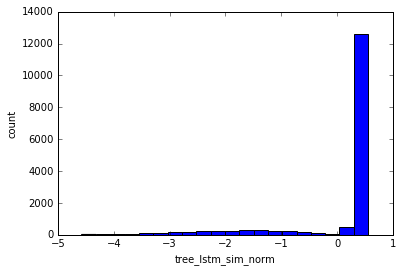

jaccard_norm
Total:	15980;		Mean:		-0.000000;	Lower 95 perc.:	2882(18.04%)
Median:	0.426311;	Median(H):	0.426311;	Median(L):	0.426311;
Max:	0.426311;	Min:		-3.967690;	Std:		1.000000




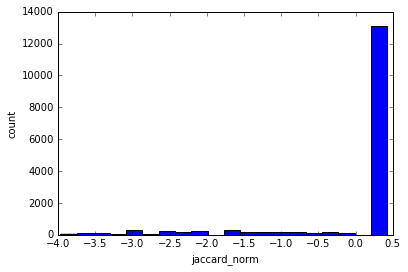

tree_lstm_sim
Total:	15980;		Mean:		4.473455;	Lower 95 perc.:	2979(18.64%)
Median:	4.779640;	Median(H):	4.779640;	Median(L):	4.779640;
Max:	4.879636;	Min:		1.131421;	Std:		0.730141




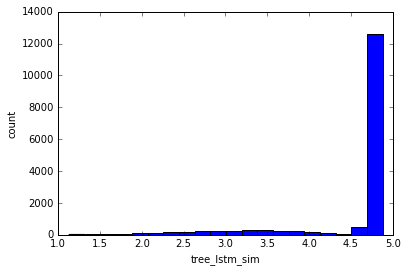

jaccard
Total:	15980;		Mean:		0.902979;	Lower 95 perc.:	2882(18.04%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.227583




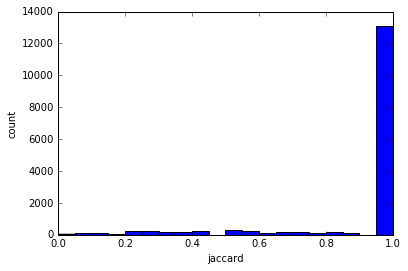

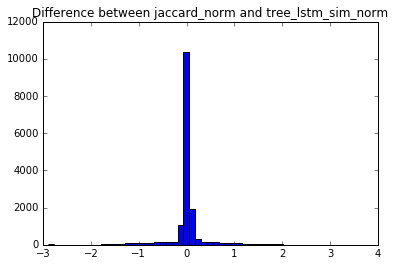

Normality Test Score:3739.15649482, 0.0
Mean Square Difference:0.136180580304


In [203]:
_,   sidx = get_expr_summary(log_file=os.path.join("stats","no_rel_text","gaussian.pkl"), 
                             datafield='tree_lstm_sim')
_,   sidx = get_expr_summary(log_file=os.path.join("stats","no_rel_text","gaussian.pkl"), 
                             datafield='jaccard')
log, sidx = get_expr_summary(log_file=os.path.join("stats","no_rel_text","gaussian.pkl"),
                             datafield='tree_lstm_sim', show_normalized=False)
log, sidx = get_expr_summary(log_file=os.path.join("stats","no_rel_text","gaussian.pkl"),
                            datafield='jaccard', show_normalized=False)
show_score_diff(log, 'jaccard_norm', 'tree_lstm_sim_norm')



tree_lstm_sim_norm
Total:	15980;		Mean:		-0.000000;	Lower 95 perc.:	15267(95.54%)
Median:	0.602924;	Median(H):	0.602924;	Median(L):	0.602924;
Max:	0.718753;	Min:		-3.425873;	Std:		1.000000




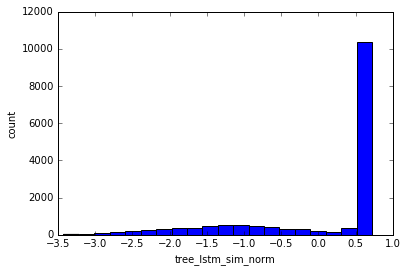

jaccard_norm
Total:	15980;		Mean:		0.000000;	Lower 95 perc.:	5320(33.29%)
Median:	0.634227;	Median(H):	0.634227;	Median(L):	0.634227;
Max:	0.634227;	Min:		-2.699330;	Std:		1.000000




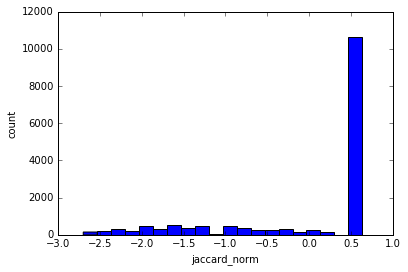

tree_lstm_sim
Total:	15980;		Mean:		4.236897;	Lower 95 perc.:	5397(33.77%)
Median:	4.777700;	Median(H):	4.777700;	Median(L):	4.777700;
Max:	4.881594;	Min:		1.164003;	Std:		0.896967




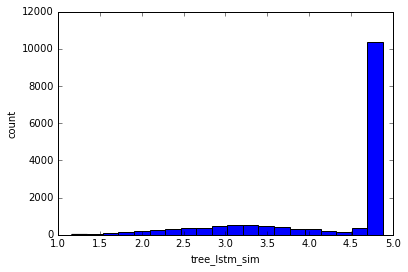

jaccard
Total:	15980;		Mean:		0.809745;	Lower 95 perc.:	5320(33.29%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.299980




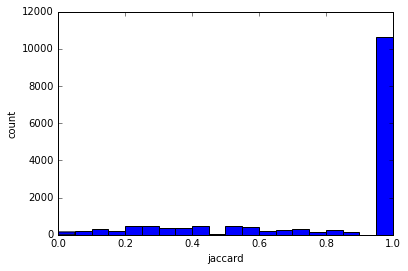

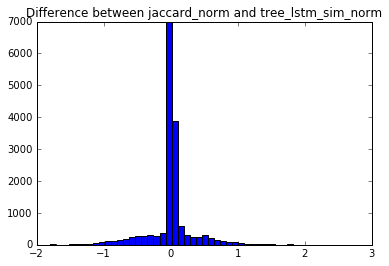

Normality Test Score:1993.18284763, 0.0
Mean Square Difference:0.118716334841


In [204]:
_, _      = get_expr_summary(log_file=os.path.join("stats","no_rel_text","blackout.pkl"), 
                             datafield='tree_lstm_sim')
log, sidx = get_expr_summary(log_file=os.path.join("stats","no_rel_text","blackout.pkl"), 
                             datafield='jaccard')

_, _      = get_expr_summary(log_file=os.path.join("stats","no_rel_text","blackout.pkl"), 
                             datafield='tree_lstm_sim', show_normalized=False)
log, sidx = get_expr_summary(log_file=os.path.join("stats","no_rel_text","blackout.pkl"), 
                             datafield='jaccard', show_normalized=False)
show_score_diff(log, 'jaccard_norm', 'tree_lstm_sim_norm')

tree_lstm_sim_norm
Total:	15980;		Mean:		-0.000000;	Lower 95 perc.:	15932(99.70%)
Median:	0.384068;	Median(H):	0.384074;	Median(L):	0.384061;
Max:	0.526100;	Min:		-4.940677;	Std:		1.000000




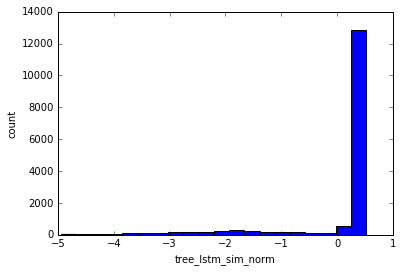

jaccard_norm
Total:	15980;		Mean:		0.000000;	Lower 95 perc.:	2549(15.95%)
Median:	0.397116;	Median(H):	0.397116;	Median(L):	0.397116;
Max:	0.397116;	Min:		-4.216303;	Std:		1.000000




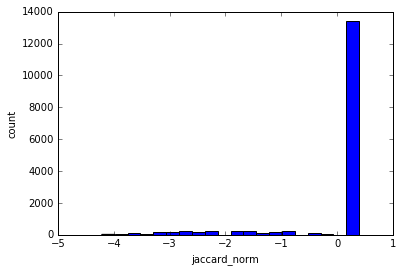

tree_lstm_sim
Total:	15980;		Mean:		4.517174;	Lower 95 perc.:	2644(16.55%)
Median:	4.780784;	Median(H):	4.780788;	Median(L):	4.780779;
Max:	4.878270;	Min:		1.126073;	Std:		0.686364




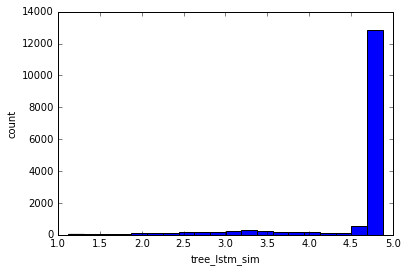

jaccard
Total:	15980;		Mean:		0.913922;	Lower 95 perc.:	2549(15.95%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.216759




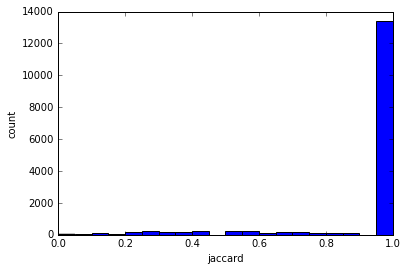

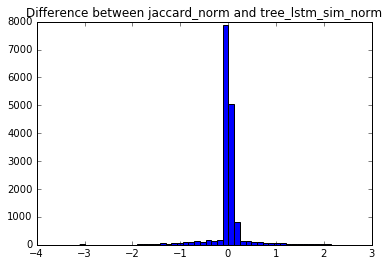

Normality Test Score:3742.44042185, 0.0
Mean Square Difference:0.135183725912


In [205]:
log, sidx = get_expr_summary(log_file=os.path.join("stats","no_rel_text","median.pkl"), datafield='tree_lstm_sim')
log, sidx = get_expr_summary(log_file=os.path.join("stats","no_rel_text","median.pkl"), datafield='jaccard')

log, sidx = get_expr_summary(log_file=os.path.join("stats","no_rel_text","median.pkl"), datafield='tree_lstm_sim', show_normalized=False)
log, sidx = get_expr_summary(log_file=os.path.join("stats","no_rel_text","median.pkl"), datafield='jaccard', show_normalized=False)

show_score_diff(log, 'jaccard_norm', 'tree_lstm_sim_norm')


tree_lstm_sim_norm
Total:	5556;		Mean:		0.000000;	Lower 95 perc.:	5158(92.84%)
Median:	0.566490;	Median(H):	0.566492;	Median(L):	0.566487;
Max:	0.679258;	Min:		-3.885733;	Std:		1.000000




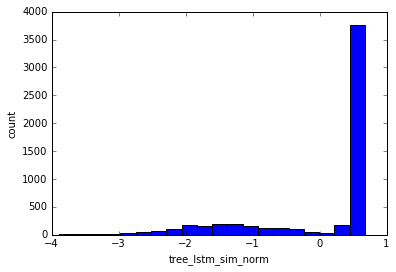

jaccard_norm
Total:	5556;		Mean:		-0.000000;	Lower 95 perc.:	1673(30.11%)
Median:	0.591364;	Median(H):	0.591364;	Median(L):	0.591364;
Max:	0.591364;	Min:		-2.875928;	Std:		1.000000




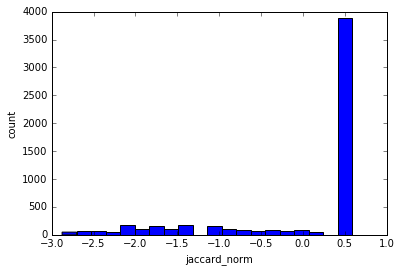

tree_lstm_sim
Total:	5556;		Mean:		4.323064;	Lower 95 perc.:	1711(30.80%)
Median:	4.782078;	Median(H):	4.782080;	Median(L):	4.782076;
Max:	4.873451;	Min:		1.174542;	Std:		0.810277




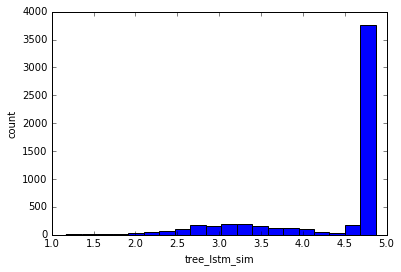

jaccard
Total:	5556;		Mean:		0.829445;	Lower 95 perc.:	1673(30.11%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.288410




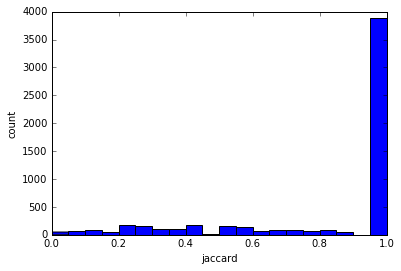

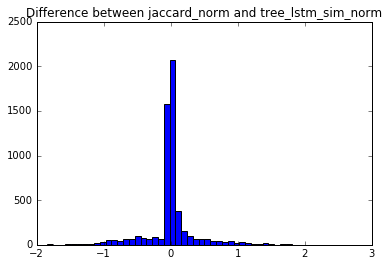

Normality Test Score:821.600016632, 3.90681838313e-179
Mean Square Difference:0.133713656698


In [206]:
log, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","gaussian.pkl"), datafield='tree_lstm_sim')
log, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","gaussian.pkl"))
log, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","gaussian.pkl"), datafield='tree_lstm_sim', show_normalized=False)
log, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","gaussian.pkl"), show_normalized=False)
show_score_diff(log, 'jaccard_norm', 'tree_lstm_sim_norm')

tree_lstm_sim_norm
Total:	5556;		Mean:		0.000000;	Lower 95 perc.:	5158(92.84%)
Median:	0.566490;	Median(H):	0.566492;	Median(L):	0.566487;
Max:	0.679258;	Min:		-3.885733;	Std:		1.000000




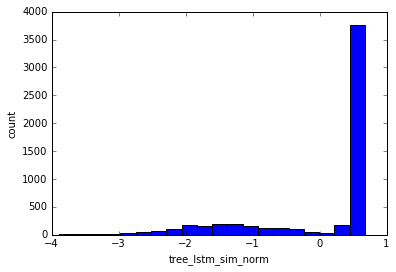

jaccard_norm
Total:	5556;		Mean:		-0.000000;	Lower 95 perc.:	1673(30.11%)
Median:	0.591364;	Median(H):	0.591364;	Median(L):	0.591364;
Max:	0.591364;	Min:		-2.875928;	Std:		1.000000




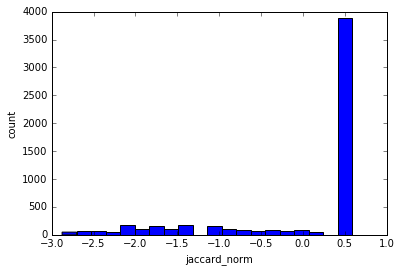

tree_lstm_sim
Total:	5556;		Mean:		4.323064;	Lower 95 perc.:	1711(30.80%)
Median:	4.782078;	Median(H):	4.782080;	Median(L):	4.782076;
Max:	4.873451;	Min:		1.174542;	Std:		0.810277




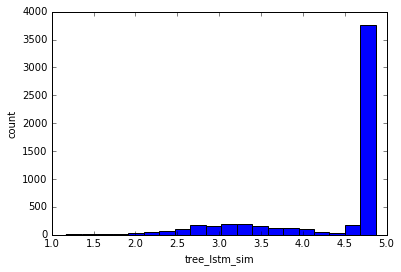

jaccard
Total:	5556;		Mean:		0.829445;	Lower 95 perc.:	1673(30.11%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.288410




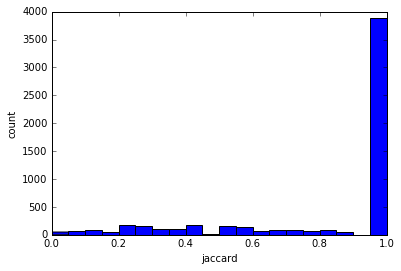

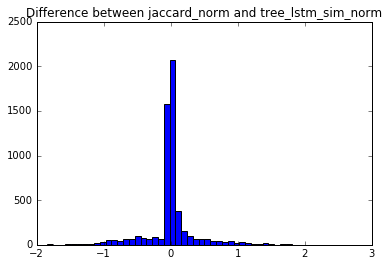

Normality Test Score:821.600016632, 3.90681838313e-179
Mean Square Difference:0.133713656698


In [207]:
log, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","blackout.pkl"), datafield='tree_lstm_sim')
log, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","blackout.pkl"))
log, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","blackout.pkl"), datafield='tree_lstm_sim', show_normalized = False)
log, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","blackout.pkl"), show_normalized = False)
show_score_diff(log, 'jaccard_norm', 'tree_lstm_sim_norm')

tree_lstm_sim_norm
Total:	5556;		Mean:		-0.000000;	Lower 95 perc.:	5468(98.42%)
Median:	0.504471;	Median(H):	0.504471;	Median(L):	0.504471;
Max:	0.639004;	Min:		-4.105694;	Std:		1.000000




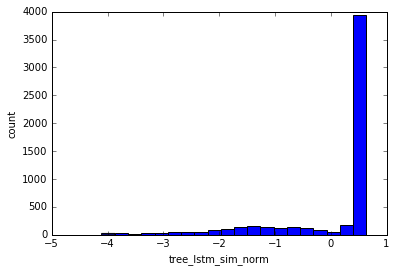

jaccard_norm
Total:	5556;		Mean:		0.000000;	Lower 95 perc.:	1475(26.55%)
Median:	0.541168;	Median(H):	0.541168;	Median(L):	0.541168;
Max:	0.541168;	Min:		-3.137570;	Std:		1.000000




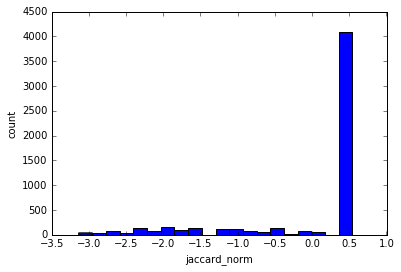

tree_lstm_sim
Total:	5556;		Mean:		4.313300;	Lower 95 perc.:	1476(26.57%)
Median:	4.696978;	Median(H):	4.696978;	Median(L):	4.696978;
Max:	4.799298;	Min:		1.190687;	Std:		0.760557




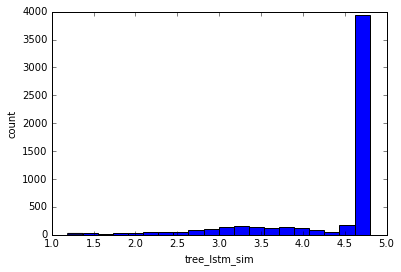

jaccard
Total:	5556;		Mean:		0.852893;	Lower 95 perc.:	1475(26.55%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.271832




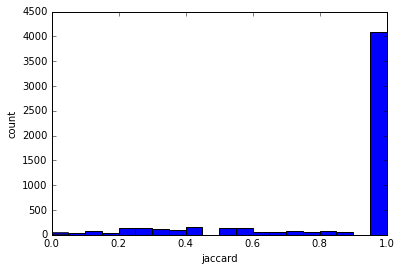

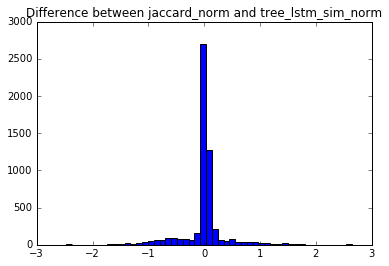

Normality Test Score:1091.3223876, 1.05282101322e-237
Mean Square Difference:0.171823497069


In [208]:
logs, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","median.pkl"), datafield='tree_lstm_sim')
logs, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","median.pkl"))
logs, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","median.pkl"), datafield='tree_lstm_sim', show_normalized=False)
logs, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","median.pkl"), show_normalized=False)
show_score_diff(logs, 'jaccard_norm', 'tree_lstm_sim_norm')

jaccard_norm
Total:	82081;		Mean:		-0.000000;	Lower 95 perc.:	68238(83.13%)
Median:	-0.378509;	Median(H):	-0.378509;	Median(L):	-0.378509;
Max:	1.797103;	Min:		-1.103713;	Std:		1.000000




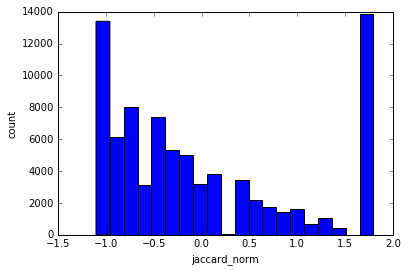

tree_lstm_sim_norm
Total:	82081;		Mean:		0.000000;	Lower 95 perc.:	75463(91.94%)
Median:	-0.197828;	Median(H):	-0.197828;	Median(L):	-0.197828;
Max:	1.815775;	Min:		-1.744220;	Std:		1.000000




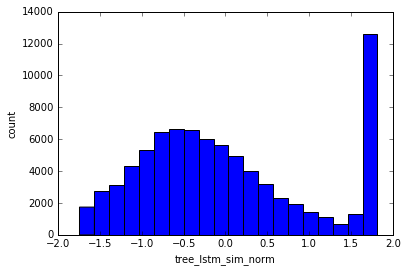

jaccard
Total:	82081;		Mean:		0.380484;	Lower 95 perc.:	68238(83.13%)
Median:	0.250000;	Median(H):	0.250000;	Median(L):	0.250000;
Max:	1.000000;	Min:		0.000000;	Std:		0.344731




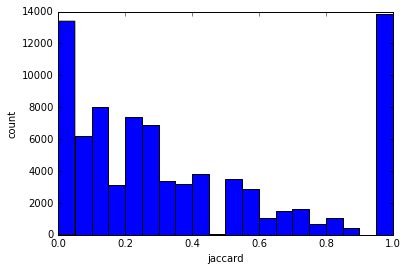

tree_lstm_sim
Total:	82081;		Mean:		2.960662;	Lower 95 perc.:	68629(83.61%)
Median:	2.751745;	Median(H):	2.751745;	Median(L):	2.751745;
Max:	4.878211;	Min:		1.118678;	Std:		1.056050




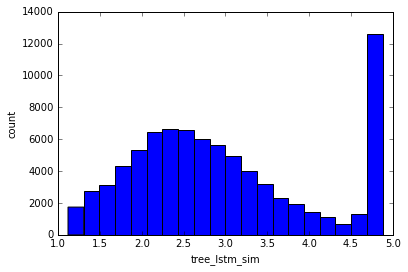

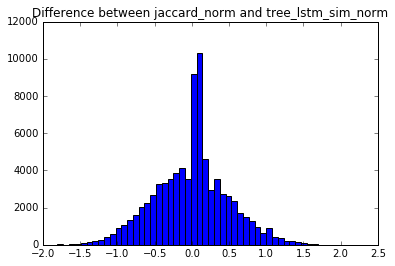

Normality Test Score:290.42669223, 8.6029041364e-64
Mean Square Difference:0.245828020751


In [209]:
logs, _ = get_expr_summary(log_file=os.path.join("stats","no_text","bgdestroy.pkl"))
logs, _ = get_expr_summary(log_file=os.path.join("stats","no_text","bgdestroy.pkl"), datafield='tree_lstm_sim')
logs, _ = get_expr_summary(log_file=os.path.join("stats","no_text","bgdestroy.pkl"), show_normalized=False)
logs, _ = get_expr_summary(log_file=os.path.join("stats","no_text","bgdestroy.pkl"), datafield='tree_lstm_sim', show_normalized=False)
show_score_diff(logs, 'jaccard_norm', 'tree_lstm_sim_norm')